In [ ]:
import os, pickle
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.applications import ResNet50
from keras.utils import load_img
from sklearn.utils import shuffle
import keras
import cv2
from matplotlib import pyplot as plt


First we load the datasets

In [ ]:
train_imgs = []
train_labels = []
all_labels = {}
cnt = 0;
for directory in os.listdir("./refactored/train"):
    all_labels[cnt] = directory
    train_labels.append(list(np.full(len(os.listdir("./refactored/train/"+directory)),directory)))
    for file in os.listdir("./refactored/train/"+directory):
        img = cv2.normalize(np.array(load_img("./refactored/train/"+directory+"/"+file)),None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        train_imgs.append(img)
    cnt += 1
    print(cnt,end=';')
train_labels = np.concatenate(train_labels)

1;2;3;4;5;6;7;8;9;10;

In [ ]:
validation_imgs = []
validation_labels = []
for directory in os.listdir("./refactored/validation"):
    validation_labels.append(list(np.full(len(os.listdir("./refactored/validation/"+directory)),directory)))
    for file in os.listdir("./refactored/validation/"+directory):
        img = cv2.normalize(np.array(load_img("./refactored/validation/"+directory+"/"+file)),None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        validation_imgs.append(img)
validation_labels = np.concatenate(validation_labels)

We use one-hot encoding on labels

In [ ]:
for label in all_labels:
    train_labels = [label if x == all_labels[label] else x for x in train_labels]
    validation_labels = [label if x == all_labels[label] else x for x in validation_labels]
train_imgs, train_labels = shuffle(train_imgs, train_labels)
validation_imgs, validation_labels = shuffle(validation_imgs, validation_labels)

In [ ]:
train_imgs = np.array(train_imgs)
validation_imgs = np.array(validation_imgs)
train_imgs.shape

(621, 128, 128, 3)

Saliency maps definition - inspired by https://github.com/experiencor/deep-viz-keras/blob/master/saliency.py


In [ ]:
class SaliencyMask(object):
    def __init__(self, model, output_index=0):
        pass

    def get_mask(self, input_image):
        pass

    def get_smoothed_mask(self, input_image, stdev_spread=.2, nsamples=1):
        stdev = stdev_spread * (np.max(input_image) - np.min(input_image))

        total_gradients = np.zeros((input_image.shape[1:3]), dtype = np.float64)
        for i in range(nsamples):
            noise = np.random.normal(0, stdev, input_image.shape)
            x_value_plus_noise = input_image + noise

            total_gradients += np.reshape(self.get_mask(x_value_plus_noise),input_image.shape[1:3])
        return total_gradients / nsamples
    
class VisualBackprop(SaliencyMask):
    def __init__(self, model, output_index = 0):
        inps = [model.input]           # input placeholder
        outs = [layer.output for layer in model.layers]    # all layer outputs
        self.forward_pass = keras.backend.function(inps, outs)         # evaluation function
        
        self.model = model

    def get_mask(self, input_image):
        x_value = input_image
        
        visual_bpr = []
        layer_outs = self.forward_pass([x_value])
        for i in range(len(self.model.layers) - 1, -1, -1):
            if 'Conv2D' in str(type(self.model.layers[i])):
                layer = np.mean(layer_outs[i], axis = -1, keepdims = True)
                layer = layer - np.min(layer)
                layer = layer / (np.max(layer) - np.min(layer) + 1e-6)
                if np.array(visual_bpr).size != 0:
                    if visual_bpr.shape != layer.shape:
                        visual_bpr = self._deconv(visual_bpr)
                    visual_bpr = visual_bpr * layer
                else:
                    visual_bpr = np.array(layer)
        return visual_bpr[0]
    
    def _deconv(self, feature_map):
        x = keras.layers.Input(shape = (None, None, 1))
        y = keras.layers.Conv2DTranspose(filters = 1, 
                            kernel_size = (3, 3), 
                            strides = (2, 2), 
                            padding = 'same', 
                            kernel_initializer = keras.initializers.Ones(), 
                            bias_initializer = keras.initializers.Zeros())(x)

        deconv_model = keras.models.Model(inputs=[x], outputs=[y])
        inps = [deconv_model.input]   
        outs = [deconv_model.layers[-1].output]
        deconv_func = keras.backend.function(inps, outs)
        
        return deconv_func([feature_map])[0]


We run data augmentation on our dataset

In [ ]:
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation((0,90))
            ]
)

In [ ]:
aug_train_imgs = []
aug_train_labels = []
for img_index in range (len(train_labels)):
    if img_index % 100 == 0:
      print(img_index,end=';')
    for i in range (15):
        aug_train_labels.append(train_labels[img_index])
        aug_train_imgs.append(data_augmentation(train_imgs[img_index]))

0;100;200;300;400;500;600;

In [ ]:
aug_train_imgs = np.array(aug_train_imgs)
validation_imgs = np.array(validation_imgs)
aug_train_imgs, aug_train_labels = shuffle(aug_train_imgs, aug_train_labels)
validation_imgs, validation_labels = shuffle(validation_imgs, validation_labels)

In [ ]:
train_imgs.shape

(621, 128, 128, 3)

Now we setup a neural network and fit it to data

In [ ]:
import tensorflow as tf



input_data = keras.Input(dtype=tf.float32, shape = ( train_imgs.shape[1], train_imgs.shape[2], 3))
input_labels = keras.Input(dtype = tf.int32, shape = (None, 1))

batch_norm1 = keras.layers.BatchNormalization()
batch_norm2 = keras.layers.BatchNormalization()
batch_norm3 = keras.layers.BatchNormalization()
batch_norm4 = keras.layers.BatchNormalization()
batch_norm5 = keras.layers.BatchNormalization()
batch_norm6 = keras.layers.BatchNormalization()

pool1 = keras.layers.MaxPooling2D((2, 2), (2, 2))
pool2 = keras.layers.MaxPooling2D((2, 2), (2, 2))
pool3 = keras.layers.MaxPooling2D((2, 2), (2, 2))
pool4 = keras.layers.MaxPooling2D((2, 2), (2, 2))
pool5 = keras.layers.MaxPooling2D((2, 2), (2, 2))
pool6 = keras.layers.MaxPooling2D((2, 2), (2, 2))

conv1 = keras.layers.Conv2D(32, (3, 3), (1, 1),padding = "same",  activation=tf.nn.relu)

conv2 = keras.layers.Conv2D(32, (3, 3), (1, 1), padding="same",activation=tf.nn.relu)

conv3 = keras.layers.Conv2D(64, (3, 3), (1, 1), padding="same",activation=tf.nn.relu)

conv4 = keras.layers.Conv2D(256, (3, 3), (1, 1), padding="same",activation=tf.nn.relu)

conv5 = keras.layers.Conv2D(512, (3, 3), (1, 1), padding="same",activation=tf.nn.relu)

conv6 = keras.layers.Conv2D(1024, (3, 3), (1, 1), padding="same",activation=tf.nn.relu)


drop = keras.layers.Dropout(0.50)

logits = keras.layers.Dense(len(all_labels.keys()),activation="softmax", kernel_regularizer='l1')
glob_pool = keras.layers.GlobalAveragePooling2D()
model = keras.models.Sequential()
model.add(input_data)

model.add(conv1)
model.add(batch_norm1)
model.add(pool1)

model.add(conv2)
model.add(batch_norm2)
model.add(pool2)


model.add(conv3)
model.add(batch_norm3)
model.add(pool3)


model.add(conv4)
model.add(batch_norm4)
model.add(pool4)

model.add(conv5)
model.add(batch_norm5)
model.add(pool5)

model.add(conv6)
model.add(batch_norm6)
model.add(pool6)

model.add(glob_pool)
model.add(drop)
model.add(logits)

We use RMSprop optimizer with Exponential  learning rate decay.

In [ ]:
lr_schedule = keras.optimizers.schedules.learning_rate_schedule.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.9)
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
                optimizer=keras.optimizers.RMSprop(learning_rate=lr_schedule),
                metrics=["accuracy"])



In [ ]:
hist_augmented = model.fit(
   aug_train_imgs,np.array(aug_train_labels), 
   batch_size = 30,
   epochs = 15,

    callbacks=[
    keras.callbacks.ModelCheckpoint("save_at_{epoch}_augmented.keras"),
],
    validation_data=(validation_imgs,np.array(validation_labels))
)

Epoch 1/15
311/311 [==============================] - 5s 12ms/step - loss: 3.9824 - accuracy: 0.8579 - val_loss: 7.8671 - val_accuracy: 0.1168
Epoch 2/15
311/311 [==============================] - 4s 11ms/step - loss: 1.7653 - accuracy: 0.9996 - val_loss: 2.8442 - val_accuracy: 0.3175
Epoch 3/15
311/311 [==============================] - 4s 11ms/step - loss: 0.4985 - accuracy: 0.9999 - val_loss: 2.0304 - val_accuracy: 0.4051
Epoch 4/15
311/311 [==============================] - 4s 11ms/step - loss: 0.2277 - accuracy: 1.0000 - val_loss: 1.9678 - val_accuracy: 0.4124
Epoch 5/15
311/311 [==============================] - 4s 11ms/step - loss: 0.1867 - accuracy: 1.0000 - val_loss: 2.0322 - val_accuracy: 0.3978
Epoch 6/15
311/311 [==============================] - 4s 11ms/step - loss: 0.1701 - accuracy: 1.0000 - val_loss: 2.0296 - val_accuracy: 0.4197
Epoch 7/15
311/311 [==============================] - 4s 11ms/step - loss: 0.1595 - accuracy: 1.0000 - val_loss: 2.0720 - val_accuracy: 0.4124

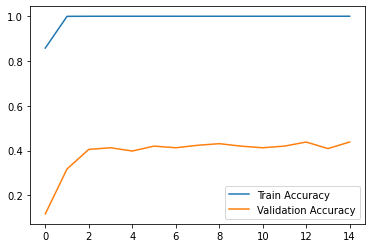

In [ ]:
plt.plot(hist_augmented.history['accuracy'],label='Train Accuracy')
plt.plot(hist_augmented.history['val_accuracy'],label='Validation Accuracy')
plt.legend()

We print out the saliency maps for the network

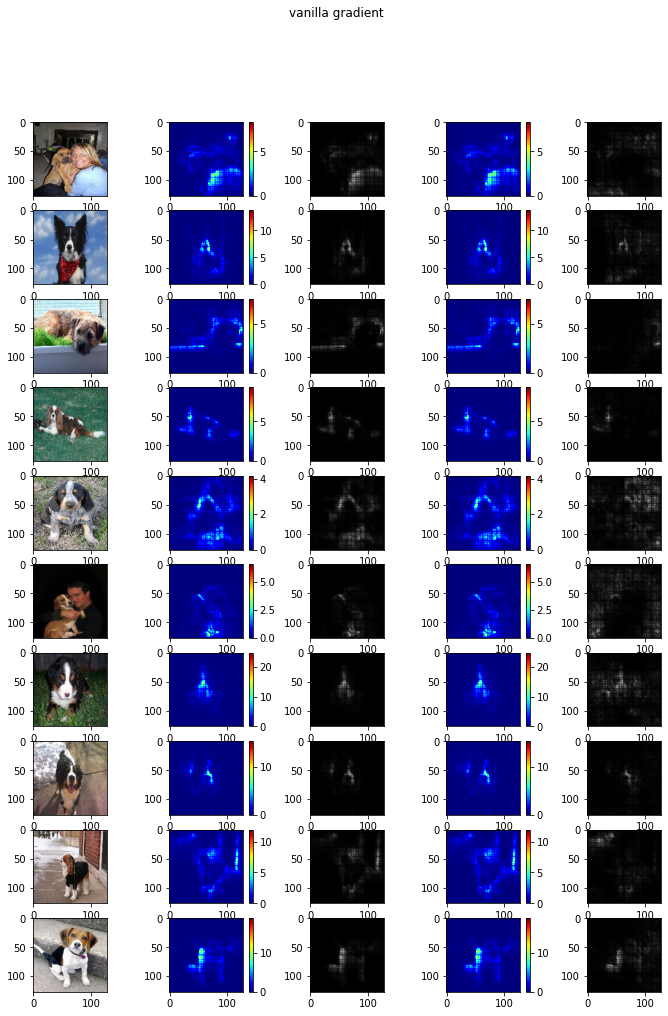

In [ ]:
fig, ax = plt.subplots(10, 5, figsize = (12, 16))
fig.suptitle('vanilla gradient')
for i in range(10):
    img = np.array([train_imgs[i]])
    
    vanilla = VisualBackprop(model, train_labels[i])
    mask = np.reshape(vanilla.get_mask(img),(128,128))
    filter_mask = (mask>0.0)
    smooth_mask = vanilla.get_smoothed_mask(img)
    filter_smoothed_mask = (smooth_mask > 0.0)

    ax[i, 0].imshow(img.reshape((128, 128,3)), cmap = 'gray')
    cax = ax[i, 1].imshow(mask, cmap = 'jet')
    fig.colorbar(cax, ax = ax[i, 1])
    ax[i, 2].imshow(mask * filter_mask, cmap = 'gray')
    cax = ax[i, 3].imshow(mask, cmap = 'jet')
    fig.colorbar(cax, ax = ax[i, 3])
    ax[i, 4].imshow(np.reshape(smooth_mask,(128,128)) * filter_smoothed_mask[0], cmap = 'gray')

We try how the saliency baseed croping results look

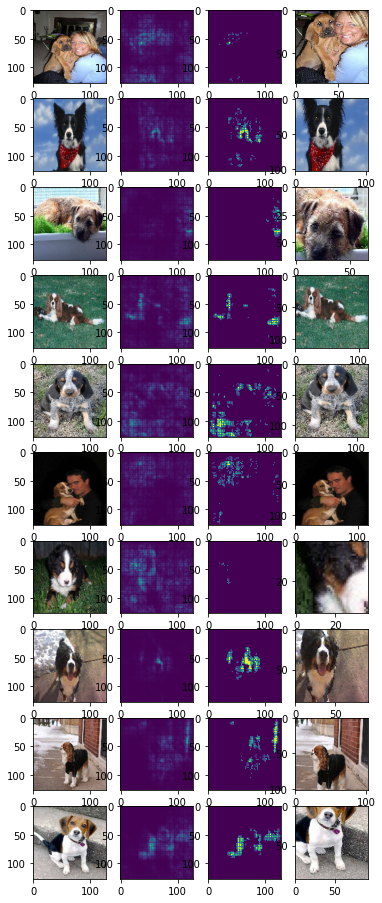

In [ ]:
fig, ax = plt.subplots(10, 4, figsize = (6, 16))
cnt = 0
for i in range(0,10):
  img = np.array([train_imgs[i]])
  vanilla = VisualBackprop(model, train_labels[i])
  smooth_mask = vanilla.get_smoothed_mask(img)


  tobin = np.array(smooth_mask, dtype = np.uint8)
  binarized = cv2.adaptiveThreshold(tobin, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                          cv2.THRESH_BINARY, 251,-0.15)

  coords = cv2.findNonZero(binarized)
  x,y,w,h = cv2.boundingRect(coords)
  ax[cnt, 0].imshow(img[0])
  ax[cnt, 1].imshow(smooth_mask)
  ax[cnt, 2].imshow(binarized)
  #ax[cnt, 3].imshow(cv2.rectangle(img[0],(x,y),(x+w,y+h),(0,255,0),1))
  cropped_image = img[0][min(y,img[0].shape[0] - max(h,w)):min(img[0].shape[0],y+max(h,w)), min(x,img[0].shape[1] - max(h,w)):min(img[0].shape[1],x+max(h,w)),:]
  #cropped_image  = img[0][y:y+h, x:x+w,:]
  if cropped_image.shape[0]<img[0].shape[0]/4:
    cropped_image = img[0]
  ax[cnt, 3].imshow(cropped_image)
  cnt += 1


We save the model

In [ ]:
model.save("saliency_crop_model.h5")